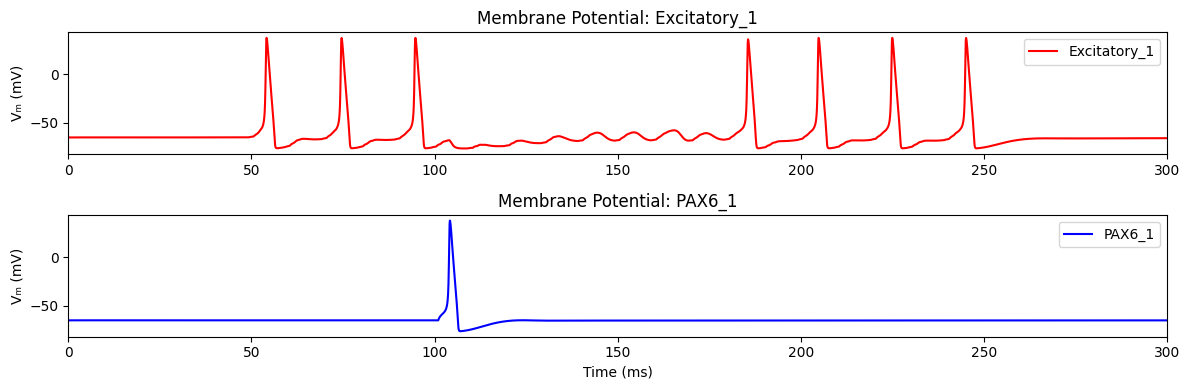

In [3]:
import numpy as np  # numerical arrays and RNG
import matplotlib.pyplot as plt  # plotting
from neuron import h  # NEURON hoc interface (h)
import random

# Load NEURON's standard run system (defines finitialize, continuerun, run control helpers)
h.load_file("stdrun.hoc")

class HHNeuron:
    def __init__(self, name, adapt_gmax=0.0005, adapt_tau=100, soma_L=30, soma_diam=30):
        self.soma = h.Section(name=name)  # create a soma section with a specific name
        self.soma.L = soma_L  # soma length (µm)
        self.soma.diam = soma_diam  # soma diameter (µm)
        self.soma.Ra = 100  # axial resistivity (Ω·cm)
        self.soma.cm = 1  # membrane capacitance (µF/cm²)
        self.soma.insert('hh')  # insert Hodgkin–Huxley (Na, K, leak) mechanism

        # set HH channel densities and leak reversal for every segment in the soma
        for seg in self.soma:
            seg.hh.gnabar = 0.12  # sodium max conductance (S/cm²)
            seg.hh.gkbar = 0.036  # potassium max conductance (S/cm²)
            seg.hh.gl = 0.0003  # leak conductance (S/cm²)
            seg.hh.el = -54.3  # leak reversal potential (mV)

        # add custom adaptation point process (from your Adapt.mod) at the center of soma
        self.adapt = h.Adapt(self.soma(0.5))
        self.adapt.gmax = adapt_gmax  # adaptation max conductance (units per mod file)
        self.adapt.tau = adapt_tau  # adaptation decay time constant (ms)

        # recorders for voltage, ionic currents, adaptation current, and HH gates
        self.v = h.Vector().record(self.soma(0.5)._ref_v)  # membrane potential (mV)
        self.ina = h.Vector().record(self.soma(0.5)._ref_ina)  # sodium current density (mA/cm²)
        self.ik = h.Vector().record(self.soma(0.5)._ref_ik)  # potassium current density (mA/cm²)
        self.iadapt = h.Vector().record(self.adapt._ref_iadapt)  # adaptation current (unit per mod)
        self.m = h.Vector().record(self.soma(0.5).hh._ref_m)  # Na activation gate m
        self.h_gate = h.Vector().record(self.soma(0.5).hh._ref_h)  # Na inactivation gate h
        self.n = h.Vector().record(self.soma(0.5).hh._ref_n)  # K activation gate n
        self.spikes = h.Vector()  # will store spike times (ms)

        # spike detector: NetCon with presynaptic source = soma voltage; postsynaptic target None → detector only
        self.nc = h.NetCon(self.soma(0.5)._ref_v, None, sec=self.soma)
        self.nc.threshold = -20  # spike threshold (mV)
        self.nc.record(self.spikes)  # record threshold crossing times into self.spikes

        # NetCon to adaptation mechanism: on each threshold crossing, deliver an event to Adapt
        self.nc_adapt = h.NetCon(self.soma(0.5)._ref_v, self.adapt, sec=self.soma)
        self.nc_adapt.threshold = -20  # same threshold
        self.nc_adapt.weight[0] = 1  # event weight (Adapt.mod uses this in NET_RECEIVE)

class DetonatorInput:
    def __init__(self, target_sec, tau=1, e=0, start=100, weight=0.1):
        self.syn = h.ExpSyn(target_sec(0.5))  # single-exponential synapse on the target section
        self.syn.e = e  # synaptic reversal potential (mV); e=0 → excitatory-like
        self.syn.tau = tau  # decay time constant (ms)

        self.stim = h.NetStim()  # event generator to produce spikes
        self.stim.start = start  # time of first event (ms)
        self.stim.number = 1  # number of events (later overwritten for trains)
        self.stim.interval = 1  # interval between events (ms) if number>1

        self.nc = h.NetCon(self.stim, self.syn)  # connect NetStim events to the synapse
        self.nc.weight[0] = weight  # synaptic weight for ExpSyn
        self.isyn = h.Vector().record(self.syn._ref_i)  # record synaptic current (nA)

class PAX6Neuron(HHNeuron):
    def __init__(self, idx):
        super().__init__(name=f'pax6_{idx+1}', adapt_gmax=0.0005, adapt_tau=100)  # base HH + adaptation
        self.syn = h.ExpSyn(self.soma(0.5))  # receiving synapse for upstream RHAG/NRHAG VecStim relays
        self.syn.e = 0  # excitatory reversal
        self.syn.tau = 1  # fast decay
        self.isyn = h.Vector().record(self.syn._ref_i)  # record input syn current (nA)

class ExcNeuron(HHNeuron):
    def __init__(self, idx):
        super().__init__(name=f'exc_{idx+1}')  # excitatory-labeled HH neuron
        # Optionally: different channel properties for excitatory neurons

class InhNeuron(HHNeuron):
    def __init__(self, idx):
        super().__init__(name=f'inh_{idx+1}')  # inhibitory-labeled HH neuron
        # Optionally: different channel properties for inhibitory neurons

def make_spatial_volley_on_soma(cell, *,
                                n_syn=12,
                                base_time=250.0,    # ms, volley center
                                jitter_ms=2.0,      # per-synapse time jitter (σ)
                                weight_nS=1.0,      # each synapse strength (nS)
                                tau_ms=1.5,         # AMPA-like decay
                                seed=1):
    rng = random.Random(seed)
    synapses, stims, ncs = [], [], []

    # distribute along soma from 0.1..0.9 (avoids exact ends)
    xs = [0.1 + 0.8*i/(n_syn-1) for i in range(n_syn)]

    for x in xs:
        syn = h.ExpSyn(cell.soma(x))
        syn.e = 0.0
        syn.tau = tau_ms

        stim = h.NetStim()
        stim.start = max(0.0, rng.gauss(base_time, jitter_ms))
        stim.number = 1
        stim.interval = 1

        nc = h.NetCon(stim, syn)
        nc.weight[0] = weight_nS * 1e-3  # nS → µS
        ncs.append(nc); synapses.append(syn); stims.append(stim)

    return {"syn": synapses, "stim": stims, "nc": ncs}


# Setting Up Network

pax6_1 = PAX6Neuron(1)

e_1 = ExcNeuron(1)

pax6_1.input = DetonatorInput(pax6_1.soma, tau=1, e=0, start=100, weight=0.005)
pax6_1.input.stim.number = 1
pax6_1.input.stim.interval = 10

spatial_spikes = []
for spike_time in range(50, 250, 10):
    spatial_spikes.append(make_spatial_volley_on_soma(e_1, n_syn=12, base_time=spike_time, jitter_ms=2.0, weight_nS=0.5, tau_ms=1.5, seed=7))

mono_syn_netcons = []  # keep NetCon refs

inh_syn = h.Exp2Syn(e_1.soma(0.5))  # bi-exponential inhibitory synapse on target
inh_syn.e = -80  # inhibitory reversal (mV)
inh_syn.tau1 = 1.0   # rise time (ms)
inh_syn.tau2 = 15.0  # decay time (ms)
nc = h.NetCon(pax6_1.soma(0.5)._ref_v, inh_syn, sec=pax6_1.soma)
nc.delay = 0.1  # short synaptic delay (ms)
nc.weight[0] = 0.05  # much smaller than disyn; tune as needed

mono_syn_netcons.append(nc)  # hold reference

# Record inhibitory synaptic current onto target
if not hasattr(e_1, 'isyn_inh'):
    e_1.isyn_inh = []  # create list to hold inh current traces
e_1.isyn_inh.append(h.Vector().record(inh_syn._ref_i))  # record I_inh (nA)

t = h.Vector().record(h._ref_t)  # record global simulation time (ms)

h.finitialize(-65)  # initialize Vm to -65 mV
h.continuerun(400)  # run until 700 ms


#DATA EXTRACTION

# Convert t only once
t_np = np.array(list(t))  # time axis (ms)

def vnp(v): return np.array(list(v))  # helper: convert h.Vector to numpy array

e = [e_1]
# e_1 signals
v_e = [vnp(r.v) for r in e]  # membrane potentials
ina_e = [vnp(r.ina) for r in e]  # sodium current densities
ik_e = [vnp(r.ik) for r in e]  # potassium current densities
iadapt_e = [vnp(r.iadapt) for r in e]  # adaptation currents
isyn_e = [vnp(r.isyn_inh) for r in e]  # their synaptic currents (from DetonatorInput)
spikes_e = [vnp(r.spikes) for r in e]  # spike times (ms)

v_pax6 = np.array(list(pax6_1.v))

#PLOTTING

plt.figure(figsize=(12, 2 * 2))  # one subplot per RHAG
for i, v in enumerate(v_e):
    plt.subplot(2, 1, i + 1)
    plt.plot(t_np, v, label=f'Excitatory_{i+1}', color='r')  # plot Vm in fed
    plt.ylabel('V\u2098 (mV)')
    plt.title(f'Membrane Potential: Excitatory_{i+1}')
    plt.xlim(0, 300)  # focus on 0-300 ms window
    plt.legend()
plt.subplot(2, 1, 2)
plt.plot(t_np, v_pax6, label=f'PAX6_1', color='b')  # plot Vm in fed
plt.ylabel('V\u2098 (mV)')
plt.title(f'Membrane Potential: PAX6_1')
plt.xlim(0, 300)  # focus on 0-300 ms window
plt.legend()
plt.xlabel('Time (ms)')
plt.tight_layout()
plt.show()

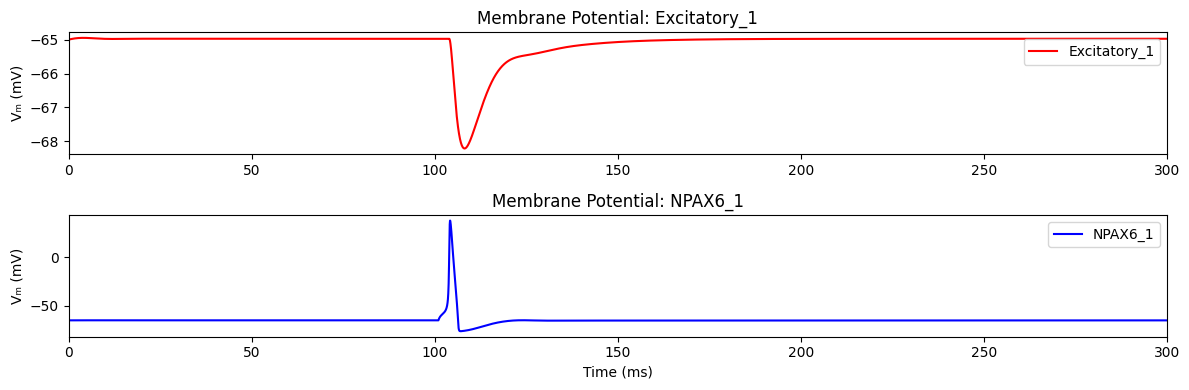

In [4]:
# Setting Up Network

npax6_1 = InhNeuron(1)

e_1 = ExcNeuron(1)

npax6_1.input = DetonatorInput(npax6_1.soma, tau=1, e=0, start=100, weight=0.005)

# spatial_spikes = []
# for spike_time in range(50, 250, 10):
#     spatial_spikes.append(make_spatial_volley_on_soma(e_1, n_syn=12, base_time=spike_time, jitter_ms=2.0, weight_nS=0.5, tau_ms=1.5, seed=7))

mono_syn_netcons = []  # keep NetCon refs

inh_syn = h.Exp2Syn(e_1.soma(0.5))  # bi-exponential inhibitory synapse on target
inh_syn.e = -80  # inhibitory reversal (mV)
inh_syn.tau1 = 1.0   # rise time (ms)
inh_syn.tau2 = 15.0  # decay time (ms)
nc = h.NetCon(npax6_1.soma(0.5)._ref_v, inh_syn, sec=npax6_1.soma)
nc.delay = 0.1  # short synaptic delay (ms)
nc.weight[0] = 0.005

mono_syn_netcons.append(nc)  # hold reference

# Record inhibitory synaptic current onto target
if not hasattr(e_1, 'isyn_inh'):
    e_1.isyn_inh = []  # create list to hold inh current traces
e_1.isyn_inh.append(h.Vector().record(inh_syn._ref_i))  # record I_inh (nA)

t = h.Vector().record(h._ref_t)  # record global simulation time (ms)

h.finitialize(-65)  # initialize Vm to -65 mV
h.continuerun(400)  # run until 700 ms


#DATA EXTRACTION

# Convert t only once
t_np = np.array(list(t))  # time axis (ms)

def vnp(v): return np.array(list(v))  # helper: convert h.Vector to numpy array

e = [e_1]
# e_1 signals
v_e = [vnp(r.v) for r in e]  # membrane potentials
ina_e = [vnp(r.ina) for r in e]  # sodium current densities
ik_e = [vnp(r.ik) for r in e]  # potassium current densities
iadapt_e = [vnp(r.iadapt) for r in e]  # adaptation currents
isyn_e = [vnp(r.isyn_inh) for r in e]  # their synaptic currents (from DetonatorInput)
spikes_e = [vnp(r.spikes) for r in e]  # spike times (ms)

v_npax6 = np.array(list(npax6_1.v))

#PLOTTING

plt.figure(figsize=(12, 2 * 2))  # one subplot per RHAG
for i, v in enumerate(v_e):
    plt.subplot(2, 1, i + 1)
    plt.plot(t_np, v, label=f'Excitatory_{i+1}', color='r')  # plot Vm in fed
    plt.ylabel('V\u2098 (mV)')
    plt.title(f'Membrane Potential: Excitatory_{i+1}')
    plt.xlim(0, 300)  # focus on 0-300 ms window
    plt.legend()
plt.subplot(2, 1, 2)
plt.plot(t_np, v_npax6, label=f'NPAX6_1', color='b')  # plot Vm in fed
plt.ylabel('V\u2098 (mV)')
plt.title(f'Membrane Potential: NPAX6_1')
plt.xlim(0, 300)  # focus on 0-300 ms window
plt.legend()
plt.xlabel('Time (ms)')
plt.tight_layout()
plt.show()